 # Image Captioning:Flickr8k

#### Data Analysing

#### Data preprocessing

In [1]:
from shutil import copyfile
import os
import numpy as np
import json

In [4]:
def load_descriptions(filepath):
    desc_file = os.path.join(filepath,'descriptions.txt')
    
    desc_dict = dict()
    
    with open(desc_file,'r') as f:
        for line in f:
            for k,v in json.loads(line).items():
                desc_dict[k] = v
    return desc_dict
def read_descriptions(filepath):
    """
    Read the annotated descriptions from the dataset
    Args : filepath for token text
    Return : A dictionary with key:image id value:decriptions
    """
    desc_dict = dict()
    with open(filepath) as f:
        for line in f:
            line_split = line.split(sep='\t')
            description = line_split[1][:-1]
            image_id = line_split[0].split('.')[0]
            if image_id not in desc_dict:
                desc_dict[image_id] = [description]
            else:
                desc_dict[image_id].append(description)
    return desc_dict

def get_ids(filepath):
    """
    Get the image ids for train-test-val split
    Args: filepath to train images text
    Returns : list containing  ids of split
    """
    ids = []
    with open(filepath) as f:
        for line in f:
            ids.append(line[:-1])
    return ids

def copyfiles(out_dir,in_dir,ids):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for _id in ids:
        in_path = os.path.join(in_dir,_id)
        out_path = os.path.join(out_dir,_id)
        copyfile(in_path,out_path)

def write_descriptions(out_dir,ids,desc_dict):
    out_path = os.path.join(out_dir,'descriptions.txt')
    output = list()
    
    for _id in ids:
        _id = _id.split('.')[0]
        output.append(json.dumps({_id:desc_dict[_id]}))
    with open(out_path,'w') as f:
        f.write('\n'.join(output))

def train_test_val_split(img_dir,token_path,input_desc_path):
    
    desc_dict = read_descriptions(token_path)
    
    images = os.listdir(img_dir)
    
    train_ids = get_ids(input_desc_path['train'])
    val_ids   = get_ids(input_desc_path['val'])
    test_ids  = get_ids(input_desc_path['test'])
    print(len(train_ids),len(val_ids),len(test_ids))
    
    copyfiles('train',img_dir,train_ids)
    copyfiles('val',img_dir,val_ids)
    copyfiles('test',img_dir,test_ids)
    
    
#     write_descriptions('train',train_ids,desc_dict)
#     write_descriptions('val',train_ids,desc_dict)
#     write_descriptions('test',train_ids,desc_dict)
    


6000 1000 1000


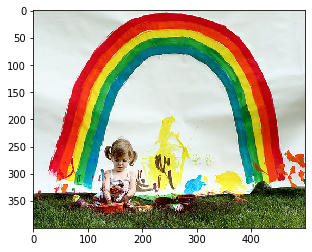

In [6]:
#Test read captions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


root = 'Flickr8k'
images = 'Flicker8k_Dataset'
ann_file = 'Flickr8k_text'
filename_token = 'Flickr8k.token.txt'
filename_train = 'Flickr_8k.trainImages.txt'
filename_val = 'Flickr_8k.devImages.txt'
filename_test = 'Flickr_8k.testImages.txt'
filepath_images = os.path.join(root,images)
filepath_token = os.path.join(root,ann_file, filename_token)
filepath_input_desc = {'train': os.path.join(root,ann_file, filename_train),
						   'val': os.path.join(root,ann_file, filename_val),
						   'test': os.path.join(root,ann_file, filename_test)
						  }

train_test_val_split(filepath_images,filepath_token,filepath_input_desc)
 
descriptions = read_descriptions(filepath_token)
for i in range(3):
    test_image  = list(descriptions.keys())[i]
    img = mpimg.imread(os.path.join(filepath_images,test_image+'.jpg'))
    imgplot = plt.imshow(img)
#     plt.show()
#     for j,desc in enumerate(descriptions[test_image]):
#         print("Captions #{} : {}".format(j,desc))


#### Prepare text data

In [6]:
import os
import nltk
from collections import Counter
import pandas as pd
import string
import re

In [13]:

# def prepare_text(desc_dict,th):
#     word2idx = dict()
#     idx2word = dict()

#     counter = Counter()
#     tokens = list()
#     for _id,descriptions in desc_dict.items():
#         for description in descriptions:
            
#             cleaned = re.sub('[^a-zA-Z]',' ',description)
            
#             tokens.extend(nltk.tokenize.word_tokenize(cleaned.lower()))
    
#     counter.update(tokens)
    
#     words = [word for word,count in counter.items() if count>= th]
    
#     identifiers = ['<unk>','<start>','<end>','<pad>']
    
#     word_list = identifiers+words
#     index = 0
#     for word in words:
#         if word not in word2idx:
#             word2idx[word] = index
#             idx2word[index] = word
#             index+=1
    
#     return word2idx,idx2word

# train_desc_dict = load_descriptions('train')
# w2id,id2w = prepare_text(train_desc_dict,10)


In [18]:
# len(w2id),len(list(set(w2id.values())))

(1658, 1658)

In [20]:
# def get_id(word,word2id_dict):
#     if word in word2id_dict:
#         return word2id_dict[word]
#     else:
#         return word2id_dict['<unk>']
# def get_word(_id,id2word_dict):
#     return id2word_dict[_id]

In [31]:
class Vocabulary():
    def __init__(self,desc_dict,th=0):
        self.word2idx = dict()
        self.idx2word = dict()
        self.idx = 0
        self.prepare_text(desc_dict,th)
    
    def get_idx(self,word):
        if word in self.word2idx:
            return self.word2idx[word]
        else:
            self.word2idx['<unk>']
    def get_word(self,idx):
        return self.idx2word[idx]
        
     
    def prepare_text(self,desc_dict,th):
        
        counter = Counter()
        tokens = list()
        for _id,descriptions in desc_dict.items():
            for description in descriptions:

                cleaned = re.sub('[^a-zA-Z]',' ',description)

                tokens.extend(nltk.tokenize.word_tokenize(cleaned.lower()))

        counter.update(tokens)

        words = [word for word,count in counter.items() if count>= th]

        identifiers = ['<unk>','<start>','<end>','<pad>']

        word_list = identifiers+words
        
        for word in words:
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx+=1
    
    def id2description(self,id_vec):
        description= ""
        for _id in id_vec:
            description += " "+self.idx2word[_id]
            if(self.idx2word[_id]=='<end>'):
                break
        return decription
    
            
train_desc = load_descriptions('train')
# print(train_desc)
vocab = Vocabulary(train_desc,6)
print(vocab.get_word(3))

poodle


#### Generate data for encoder-decoder model

In [35]:
import json  

In [36]:
class DataLoader():
    
    def __init__(self,path,vocab,transform):
        self.images = None
        self.descriptions = None
        self.vocab = vocab
        self.transform = transform
        
        self.load_descriptions(path)
        self.load_images(path)
    
    def load_images(self,path):
        img_files = os.listdir(path)
        images = dict()
        
        for img in img_files:
            if(img.endswith('.jpg')):
                img_path = os.path.join(path,img)
                images[img] = self.transform(Image.open(img_path))
            
        self.images = images
        
    def load_descriptions(self,path):
        desc_file = os.path.join(path,'descriptions.txt')
        desc_dict = dict()
        with open(desc_file,'r') as f:
            for line in f:
                for k,v in json.loads(line).items():
                    desc_dict[k] = v
        self.descriptions = desc_dict
        
    
    def  description2id(self,description):
        vocab = self.vocab
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        id_vec = list()
        
        id_vec.append(vocab.get_idx('<start>'))
        id_vec.extend([vocab.get_idx(word) for word in tokens])
        id_vec.append(vocab.get_idx('<end>'))
        
        return id_vec
    def get_descriptions(self,img_id):
        return self.descriptions[img_id]

    
    def get_image(self,img_id):
        return self.images[img_id]
    
    
    def get_input_data(self):
        images = list()
        descriptions = list()
        
        for img_id,img_descriptions in self.descriptions.items():
            len_desc = len(img_descriptions)
            images.extend([img_id]*len_desc)
            for description in img_descriptions:
                descriptions.append(self.description2id(description))
                
        data = images,descriptions
        
        return data
    
    
        
# data_loader = DataLoader('train',vocab)         
                

#### Image Encoder Model

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [39]:
class Inception(nn.Module):
    def __init__(self,embedding_size=300):
        super(Inception,self).__init__()
        inception = models.inception_v3(pretrained=True)
        modules = list(inception.children())[:-1]
        self.inception = nn.Sequential(*modules)
        self.embed = nn.Linear(inception.fc.in_features,embedding_size)
        self.bn = nn.BatchNorm1d(embedding_size,momentum=0.01)
        
        
    def forward(self,images):
        with torch.no_grad():
            feature_vec = self.inception(images)
        feature_vec = feature_vec.view(feature_vec.size(0),-1)
        feature_vec = self.embed(feature_vec)
        feature_vec = self.bn(feature_vec)
            
        return feature_vec

In [40]:
Inception()

Inception(
  (inception): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=Tru

#### Text Decoder Model

In [42]:
class Decoder(nn.Module):
    def __init__(self,embedding_size,hidden_size,vocab_size,num_layers):
        super(Decoder,self).__init__()
        self.embed = nn.Embedding(vocab_size,embedding_size)
        self.lstm  = nn.LSTM(embedding_size,hidden_size,num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_size,vocab_size)
    
    def forward(self,features,description):
        desc_len = len(description)+1
        embedding  = self.embed(description)
        embedding = torch.cat((features,embedding),0)
        lstm_out = self.lstm(embedding.unsqueee(1))
        out = self.linear(lst_out.view(desc_len,-1))
        
        return out

In [44]:
Decoder(400,512,8092,4)

Decoder(
  (embed): Embedding(8092, 400)
  (lstm): LSTM(400, 512, num_layers=4, batch_first=True)
  (linear): Linear(in_features=512, out_features=8092, bias=True)
)

In [45]:
th = 5
desc_dict = load_descriptions('train')
vocab = Vocabulary(desc_dict,th)

In [48]:
!pip install pickle-mixin

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5998 sha256=0453fdbd522edb4d5ce6439eed4184016f0d1b841aaafab6e5c796c3b0f3e1e6
  Stored in directory: /home/paraqum/.cache/pip/wheels/2a/a4/6c/83bfbc3b94f1bb43d634b07a6a893fd437a45c58b29aea5142
Successfully built pickle-mixin


In [50]:
import pickle
with open('inception_vocab.pkl','wb') as f:
    pickle.dump(vocab,f)
    

In [54]:
normalize = (0.5,0.5,0.5),(0.5,0.5,0.5)
transform = transforms.Compose([transforms.Resize((299,299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [55]:
flickr_dl  = DataLoader('train',vocab,transform)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-47fdea387768>", line 1, in <module>
    flickr_dl  = DataLoader('train',vocab,transform)
  File "<ipython-input-36-f20b0180a028>", line 10, in __init__
    self.load_images(path)
  File "<ipython-input-36-f20b0180a028>", line 19, in load_images
    images[img] = self.transform(Image.open(img_path))
  File "/home/paraqum/.local/lib/python3.5/site-packages/PIL/Image.py", line 2779, in open
    prefix = fp.read(16)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handl

KeyboardInterrupt: 

In [ ]:
data = flickr_dl.get_input_data()


In [57]:
vocab_size = vocab.idx
hidden_dim = 512
num_layers=2
image_model = Inception()
text_model = Decoder(300,hidden_dim,vocab_size,num_layers)
text_model

Decoder(
  (embed): Embedding(2529, 300)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=2529, bias=True)
)

In [58]:
if torch.cuda.is_available():
		with torch.cuda.device(args.gpu_device):
			image_model.cuda()
			text_model.cuda()

In [68]:
criterion = nn.CrossEntropyLoss()
params = list(image_model.parameters()) + list(text_model.parameters()) 
optimizer = torch.optim.Adam(params, lr =0.001)
num_epochs = 1

In [71]:
# len(list(text_model.parameters()))

11

In [72]:
import time
import matplotlib.pyplot as plt

def shuffle_data(data, seed=0):
	images, captions = data
	shuffled_images = []
	shuffled_captions = []
	num_images = len(images)
	torch.manual_seed(seed)
	perm = list(torch.randperm(num_images))
	for i in range(num_images):
		shuffled_images.append(images[perm[i]])
		shuffled_captions.append(captions[perm[i]])
	return shuffled_images, shuffled_captions

In [73]:
for epoch in range(num_epochs):
		shuffled_images, shuffled_captions = shuffle_data(data, seed = epoch)
		num_captions = len(shuffled_captions)
		loss_list = []
		tic = time.time()
		for i in range(num_captions):
			image_id = shuffled_images[i]
			image = dataloader.get_image(image_id)
			image = image.unsqueeze(0)
						
			if torch.cuda.is_available():
				with torch.cuda.device(args.gpu_device):
					image = Variable(image).cuda()
					caption = torch.cuda.LongTensor(shuffled_captions[i])
			else:
				image = Variable(image)
				caption = torch.LongTensor(shuffled_captions[i])

			caption_train = caption[:-1] # remove <end>
			image_model.zero_grad()
			text_model.zero_grad()
			
			feature_vec = image_model(image)
			text_seq = lstm(feature_vec, caption_train)
			loss = criterion(text_seq, caption)
			loss.backward()
			optimizer.step()
			loss_list.append(loss)
		toc = time.time()
		avg_loss = torch.mean(torch.Tensor(loss_list))	
		print('epoch %d avg_loss %f time %.2f mins' 
			%(epoch, avg_loss, (toc-tic)/60))		
		if epoch % args.save_iter == 0:

			torch.save(image_model.state_dict(), os.path.join(model_name, 'iter_%d_cnn.pkl'%(epoch)))
			torch.save(text_model.state_dict(), os.path.join(model_name, 'iter_%d_lstm.pkl'%(epoch)))

NameError: name 'data' is not defined